In [113]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(1)


(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")
labels_raw_portion = labels_raw[:1000]
data_raw_portion = data_raw[:1000,:]
ids_raw_portion = ids_raw[:1000]
data_, data_t_, labels, ids = process_data(data_raw_portion, t_data_raw, labels_raw_portion, ids_raw_portion, zero = False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The original dimensions of the training data set was 1000 samples and 30 columns. After feature and sample filtering, there are 909 samples and 23 columns


In [114]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_val(y, x, k, lambda_, degree):
    """get subsets for cross validation"""
    
    k_indices = build_k_indices(y, k, 0)

    for i in np.arange(k):
        te_indice = k_indices[i]
        tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == i)]
        tr_indice = tr_indice.reshape(-1)
        y_te = y[te_indice]
        y_tr = y[tr_indice]
        x_te = x[te_indice]
        x_tr = x[tr_indice]
        
        # standardize the sets
        
        x_train, mean, variance = standardize(x_tr)
        x_test = standardize_test(x_te, mean, variance)
    
        yield np.array(y_tr), np.array(x_train), np.array(y_te), np.array(x_test) #this is a generator! call next(object) for next set

In [127]:
def least_squares_GD(y, tx, initial_w, tol = 1e-5, max_iters = 10000, gamma = 0.05, k=4,  write = False):
    """Gradient descent algorithm with option for cross validation. 
    
    For cross validation: If k is set to > 0, then the function returns
    the average test loss between the trials, the variance between the trials, the vector of test losses over 
    gradient descent (for each cross validation, so it is a list of lists), the training loss and the 
    last w that was retrieved from the last trial (if one wants to use it for plotting etc)
    
    For retrieving the optimal w: If k is set to 0, the entire y and tx values given to the function will
    be used to calculate the optimal w. the only value that will be returned is w"""
    
    gen = cross_val(y, tx, k, 0.01, 2) # initiate generator object
    test_loss = []
    test_losses_vector = []
    training_loss = []

    # This if is for a final model, that is - if we want to get the best w's (so use all training samples)
    
    if k == 0:
        n_iter = 0
        w = initial_w
        while n_iter < max_iters:
            # compute gradient
            gd = compute_gradient(y, tx, w)
            # compute next w
            w = w - gamma*gd
            n_iter += 1
            
        return w
    
    # This else is for determining if this is a good way to select the model - return test and training errors
    else:
        for i in np.arange(k):
            y_tr, x_tr, y_te, x_te = next(gen)

            # Define parameters to store w and loss
            # ws = [initial_w]
            w = initial_w
            my_losses = [compute_loss(y_tr, x_tr, w)]
            loss = my_losses[0]
            n_iter=0
            while n_iter < max_iters:
                # compute gradient
                gd = compute_gradient(y_tr, x_tr, w)
                # compute next w
                w = w - gamma*gd
                # compute loss and diff
                loss = compute_loss(y_tr, x_tr, w)
                # store w and loss and increment
                # ws.append(w)
                n_iter += 1
                my_losses.append(loss)
                if abs(my_losses[-1] - my_losses[-2]) < tol:
                    break
                    
                if write == True:
                    print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
            test_losses_vector.append(my_losses)
            # append the test_loss to the list so it can be averaged at the end
            test_loss.append(compute_loss(y_te, x_te, w))
            training_loss.append(loss)
            
            
        return np.array(test_loss).mean(), np.array(test_loss).var(), np.array(test_losses_vector), np.array(training_loss).mean(), w


initial_w = np.zeros(data_.shape[1])
test_loss, test_variance, vector_test_loss, training_loss, w = least_squares_GD(labels, data_, initial_w, k = 4, gamma = 0.0005, max_iters = 200) # fit model and retrieve W's across iterations


In [139]:
means_over_time = vector_test_loss.mean(axis=0)
error1 = abs(means_over_time - vector_test_loss[0])
print(error1)
x = np.linspace()


[0.00000000e+00 8.19154731e-06 1.63599386e-05 2.45053045e-05
 3.26277746e-05 4.07274779e-05 4.88045421e-05 5.68590940e-05
 6.48912596e-05 7.29011640e-05 8.08889313e-05 8.88546847e-05
 9.67985466e-05 1.04720638e-04 1.12621081e-04 1.20499993e-04
 1.28357494e-04 1.36193702e-04 1.44008734e-04 1.51802707e-04
 1.59575734e-04 1.67327932e-04 1.75059414e-04 1.82770293e-04
 1.90460680e-04 1.98130688e-04 2.05780426e-04 2.13410005e-04
 2.21019532e-04 2.28609117e-04 2.36178866e-04 2.43728887e-04
 2.51259284e-04 2.58770163e-04 2.66261628e-04 2.73733782e-04
 2.81186729e-04 2.88620570e-04 2.96035406e-04 3.03431339e-04
 3.10808467e-04 3.18166890e-04 3.25506707e-04 3.32828014e-04
 3.40130910e-04 3.47415490e-04 3.54681849e-04 3.61930083e-04
 3.69160287e-04 3.76372552e-04 3.83566973e-04 3.90743642e-04
 3.97902649e-04 4.05044087e-04 4.12168044e-04 4.19274612e-04
 4.26363878e-04 4.33435932e-04 4.40490860e-04 4.47528750e-04
 4.54549688e-04 4.61553761e-04 4.68541052e-04 4.75511648e-04
 4.82465631e-04 4.894030

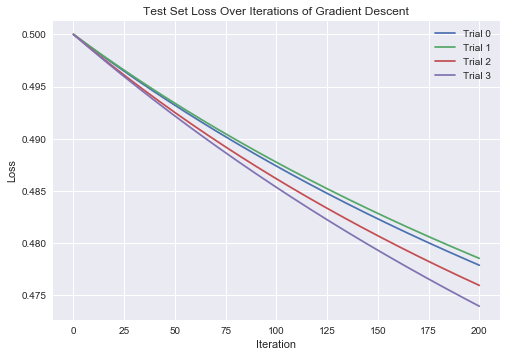

In [142]:
#make a plot of the four k's to see how they vary over time

plt.style.use('seaborn')
for i in np.arange(4):
    plt.plot(vector_test_loss[i], label= 'Trial {}'.format(i))
# plt.plot(vector_test_loss[0], label='Testing set loss', c='blue')
# plt.fill_between(x, vector_test_loss-error1, vector_test_loss+error1,
#     alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Test Set Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()